In [1]:
#from LSV import *
import pyfreeling as freeling
import sys
import re
import pandas as pd
import speech_recognition as sr
from moviepy.editor import *
from os import listdir
from IPython.display import Image as Imagepy
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 
input_path =  os.getcwd()

In [2]:
freeling.util_init_locale("default");
lang = "es" ; ipath = "/usr"
lpath = ipath + "/share/freeling/" + lang + "/"
tk=freeling.tokenizer(lpath+"tokenizer.dat");
sp=freeling.splitter(lpath+"splitter.dat");

In [3]:

def my_maco_options(lang,lpath) :

    # create options holder 
    opt = freeling.maco_options(lang);

    # Provide files for morphological submodules. Note that it is not 
    # necessary to set file for modules that will not be used.
    opt.UserMapFile = "";
    opt.LocutionsFile = lpath + "locucions.dat"; 
    opt.AffixFile = lpath + "afixos.dat";
    opt.ProbabilityFile = lpath + "probabilitats.dat"; 
    opt.DictionaryFile = lpath + "dicc.src";
    opt.NPdataFile = lpath + "np.dat"; 
    opt.PunctuationFile = lpath + "../common/punct.dat"; 
    return opt;



morfo=freeling.maco(my_maco_options(lang,lpath));
morfo.set_active_options (False,  # UserMap 
                          True,  # NumbersDetection,  
                          True,  # PunctuationDetection,   
                          False,  # DatesDetection,    
                          True,  # DictionarySearch,  
                          True,  # AffixAnalysis,  
                          False, # CompoundAnalysis, 
                          True,  # RetokContractions,
                          False,  # MultiwordsDetection,  
                          True,  # NERecognition,     
                          False, # QuantitiesDetection,  
                          True); # ProbabilityAssignment                 
tagger = freeling.hmm_tagger(lpath+"tagger.dat",True,2)
# create sense annotator
sen = freeling.senses(lpath+"senses.dat");
# create sense disambiguator
wsd = freeling.ukb(lpath+"ukb.dat");
sdb = freeling.semanticDB(lpath+"semdb.dat");
# create dependency parser
parser = freeling.dep_treeler(lpath+"dep_treeler/dependences.dat");

In [20]:
def txt_to_dict(file_path):
    final_list = ''
    with open(file_path) as lines:
        for lineItem in lines:
            attribute = lineItem.split(':')[0]
            try:
                value = lineItem.split(':')[1]
            except:
                value = lineItem
                #print ('--->Falta por clasificar')
            final_list = final_list + (attribute+':'+value+',')
    final_list = final_list.rstrip(',').replace('\n','').replace(' ','') 
    lines_dict = dict((k,v) for k, v in (e.split(':') for e in final_list.split(',')))
    return lines_dict


# In[4]:


def get_re_value(line, re_value, group_number = 0): 
    value = re.search(re_value,line)
    if not value:
        return None 
    value = value.group(group_number)
    return value


# In[5]:


def clean_input(token, list_):
    for iterator in list_:    
        val = get_re_value(token, iterator)
        if val:
            return True
    return False


# In[43]:


def is_something(syns,categories,sdb):
    is_top = False
    is_label = False
    for syn in syns:
        is_top = False
        is_label = False
        while not is_label:  
            si = sdb.get_sense_info(syn)
            for label in categories:
                is_label = (si.sumo == label)
                #print (label)
                if is_label:
                    is_top = True
                    break
                else:
                    if len(si.parents) > 0 :
                        syn = si.parents[0]
                        continue
                    else:
                        is_top = True
                        is_label = 'NoValid'
                        break
        if is_label != 'NoValid':
            return (categories[label])
    return False


# In[42]:


def is_sumo_tag(syns,label,sdb):
    is_top = False
    is_label = False
    while not is_label:
        si = sdb.get_sense_info(syns)
        is_label = (si.sumo == label)
        if is_label:
            is_top = True
            break
        else:
            if len(si.parents) > 0 :
                syns = si.parents[0]
                continue
            else:
                is_top = True
                is_label = 'NoValid'
                break
    if is_label != 'NoValid':
        return (label)
    return False




def analize_gender_number(tag):
    #DAOFS0
    #gender = [3]
    #number = [4]
    gender = '' ; number = ''
    if tag[3] == 'F' or tag[2] == 'F': gender = '$F'
    if tag[3] == 'M' or tag[2] == 'M': gender = '$M'
    if tag[3] == 'N' or tag[2] == 'N': gender = ''
    if tag[4] == 'S' or tag[3] == 'S': number = ''
    if tag[4] == 'P' or tag[3] == 'P': number = '$P'
    if tag[4] == 'N' or tag[3] == 'N': number = ''
    return (gender, number)    
        
    


# In[40]:



def is_syns_tag(syns,label,sdb):
    is_top = False ; is_label = False; a = 0
    for syn in syns:
        while not is_label and not is_top:
            si = sdb.get_sense_info(syn)
            is_label = (si.sumo == label)
            if is_label:
                is_top = True
                return True
            else:
                if len(si.parents) > 0 and a<=4:
                    a = a+1
                    syn = si.parents[0]
                else:
                    is_top = True
        is_top = False ; is_label = False
    return False
    



# In[12]:


def get_word_info(word):
    if len(word.get_senses())>0:
        try:
            syns = (word.get_senses()[0][0],word.get_senses()[1][0])
        except:
            syns = (word.get_senses()[0][0])
    else:
        syns = '' 
    return word.get_tag(),word.get_lemma(),word.get_form(),syns


# In[13]:


def get_expresions(tag,expresions, expresions_final):
    expre = ''
    if tag[0:3] in expresions_final:
        expre = (expresions_final[tag[0:3]])
        expre = ''
    else:
        if tag[0:3] in expresions:
            expre =(expresions[tag[0:3]])
    return expre


# In[14]:


def spell(name): 
    spell_name = ''
    for letter in name:
        spell_name = spell_name +str.upper(letter)+ '-'
    return spell_name.rstrip('-')


# In[16]:


def get_number(tag):
    if tag[3] == 'P' : return '$P'
    return ''


# In[17]:



       



In [70]:
def AnalizeSentense(S,O,V, s):
    Stag,Slemma,Sform,Ssyn =  get_word_info(S)
    Otag,Olemma,Oform,Osyn =  get_word_info(O)
    Vtag,Vlemma,Vform,Vsyn =  get_word_info(V)
    Slist = [S]
    Spos = s.get_word_iterator(S)
    for w,it in zip(s, range(len(s))):         
        wtag,wlemma,wform,wsyn =  get_word_info(w)
        if (wlemma != Slemma):
            if wlemma == Slemma:
                if (s[it+1].get_lemma() == 'y' or s[it+1].get_form() == ','):
                    Slist.append(s[it+2])
                    continue
    return {'O':O,'S':Slist,'V':V}
        

    

In [6]:
def get_SVO(s):
    for w in s:
        #print (w.get_lemma(),w.get_tag())
        pass
        #print (w.get_lemma(),end = ' ')
    A0 = False ;A1 = False;A2 = False;A3 =False; PRED = False; trip = False
    for pred in s.get_predicates():
        A0 = False ;A1 = False;A2 = False;A3 =False; PRED = False; trip = False
        for arg in pred :
            if arg.get_role()== "A1" : A1 = s[arg.get_position()]
            elif arg.get_role()== "A0" : A0 = s[arg.get_position()]
            elif arg.get_role()== "A2" : A2 = s[arg.get_position()]
            elif arg.get_role()== "A3" : A3 = s[arg.get_position()]
            head = s.get_dep_tree().get_node_by_pos(arg.get_position())
        if (A0 and A1):
            PRED = s[pred.get_position()]
            trip = AnalizeSentense(A0,A1,PRED,s)
        if (A1 and A2): 
            PRED = s[pred.get_position()]
            trip = AnalizeSentense(A1,A2,PRED,s)  
    #No cumple con transitividad tiene forma pasiva.        
    if not trip: return False
    else: return trip

In [7]:
def get_word_info(word):
    if len(word.get_senses())>0:
        try:
            syns = (word.get_senses()[0][0],word.get_senses()[1][0])
        except:
            syns = (word.get_senses()[0][0])
    else:
        syns = '' 
    return word.get_tag(),word.get_lemma(),word.get_form(),syns

In [8]:
def analizeVerb(w, flag):
    number = ''
    tag = w.get_tag()
    if (tag[0:2] == 'VA' or tag[0:2] == 'VS'):
        time = get_time(tag)
        lemma = w.get_lemma()
        if w.get_lemma() == 'haber' : lemma = ''
        if w.get_lemma() == 'ser': 
            if time == '$Pasado':
                time = '$SerPasado'
                lemma = ''
            elif time == '$Futuro':
                time = '$SerFuturo'
                lemma = ''
            else:
                time = '$SerPresente'
                lemma = ''       
    elif tag[0:2] == 'VM' and not flag :
        lemma = w.get_lemma()
        if lemma == 'estar':
            lemma = ''
            if tag[4:6] == '1S':
                lemma =  'YO '+lemma 
        if tag[4:6] == '2S':
            lemma =  'TU '+lemma 
        elif tag[4:6] == '3S':
            lemma =  'EL ' +lemma    
        elif tag[4:6] == '1P':
            lemma =  'NOSOTROS '+lemma 
        elif tag[4:6] == '2P':
            lemma =  'USTEDES '+lemma 
        elif tag[4:6] == '3P':
            lemma =  'ELLOS '+lemma 
        time = get_time(tag)
    else:
        lemma = w.get_lemma()
        time = get_time(tag) 
    return time, number, lemma

In [9]:
def analizeVerb_(w):
    number = ''
    tag = w.get_tag()
    if (tag[0:2] == 'VA' or tag[0:2] == 'VS'):
        time = get_time(tag)       
    elif tag[0:2] == 'VM':
        time = get_time(tag)
    return time, number

In [10]:
def extract_lemma_and_sense(w) :
    lem = w.get_lemma()
    sens=""
    if len(w.get_senses())>0 :
        sens = w.get_senses()[0][0]
    return lem, sens


In [11]:

def formatOut(lemma_out):
    out = ''
    dic_tags = {'$P': 'MUCHO','$F':'SEÑA_FEMENINO','$M':'SEÑA_MASCULINO','$Pasado':'SEÑA_PASADO','$Futuro':'SEÑA_FUTURO','$SerPresente':'SEÑA_SER_PRESENTE','$SerPasado':'SEÑA_SER_PASADO','$SerFuturo':'SEÑA_SER_FUTURO'}
    for lemma in lemma_out.split():
        if lemma in dic_tags:
            print (dic_tags[lemma],end = ' ')
            out = out +' '+ dic_tags[lemma]
        else:
            print (str.upper(lemma).replace('Á','A').replace('É','E').replace('Í','I').replace('Ó','O').replace('Ú','U').replace('Ü','U'), end = ' ')
            out = out +' '+ str.upper(lemma).replace('Á','A').replace('É','E').replace('Í','I').replace('Ó','O').replace('Ú','U').replace('Ü','U')
    return out    
    

In [12]:
def get_time(tag):    
    if tag[3] == 'P' or tag[2] == 'G' : return ''
    if tag[3] == 'F' : return '$Futuro'
    if tag[3] == 'S' or tag[3] == 'I'  : return '$Pasado'
    return ''
    

In [75]:
def ProcessSentences(ls, sdb,categories,expresions, expresion_final):    
    #exceptions=['^PP[A-Z0-9]{3}D','SP','^PR0','^P0','^DI','^DA','Fd','Flt','Fla','Fe','Frc','Fra','Fx', 'Faa','Fat','Fia','Fit','Fp']
    exceptions_=['Fc','^PR0','^DI','^DA','Fd','Flt','Fla','Fe','Frc','Fra','Fx', 'Faa','Fat','Fia','Fit','Fp']
    female_words = ['mujer','dama','madre','mamá']
    s_aux = freeling.sentence();
    expre = '' ; gender = ''; number = '' ; time = '' ; verb_aux = False ; verb_number = False; flag = False
    out = ''; o_rest = freeling.sentence() ;  s_rest = freeling.sentence() ;  v_rest = freeling.sentence()
    for s in ls :
        for w in s:
            if (clean_input(list_=exceptions_,token=w.get_tag())):
                    continue
            s_aux.push_back(w)
            print (w.get_lemma(), w.get_tag())
        s_aux = parser.analyze(s_aux)
        leng = len(s_aux)
        SVO = get_SVO(s_aux) 
        out = ''; o_rest = freeling.sentence() ;  s_rest = freeling.sentence() ;  v_rest = freeling.sentence()
        if (SVO):
            print ('Estructura')
            Slemma_ = ''
            for subj,Sit in zip(SVO['S'],range(len(SVO['S']))):
                Stag,Slemma,Sform,Ssyn = get_word_info(subj)  
                if Stag[0] == 'N' :
                    if (Stag[0:2] == 'NC'):
                        if not is_syns_tag(Ssyn,'Human=',sdb):
                            Snumber = get_number(Stag)
                            Sgender = '' 
                        else:
                            (Sgender, Snumber)= analize_gender_number(Stag)
                    else:
                        #Se deletran los nombres propios.
                        Slemma = spell(Slemma)  
                        Sgender = ''; Snumber = ''
                else:  
                    if (Stag[0] == 'P' or Stag[0] == 'D'):
                        (Sgender, Snumber)= analize_gender_number(Stag)
                    else:
                        Snumber = '' ; Sgender = ''
                if (Slemma.replace(' ','') in female_words): Sgender = ''
                if len(SVO['S']) > 1 and Sit >= 1 : Slemma_ = Slemma_+' Y '+Slemma
                else: Slemma_ = Slemma_+' '+Slemma      
            Slemma = Slemma_
            ##Analizo si hay resto entre el sujeto y el verbo
            s_flag = False
            for s_iterator in range(leng): 
                if s_aux[s_iterator].get_lemma() == SVO['V'].get_lemma():
                    s_flag = False 
                if s_flag == True:
                    s_rest.push_back(s_aux[s_iterator])
                if s_aux[s_iterator].get_lemma() == SVO['S'][0].get_lemma():
                    s_flag = True 
            print (Slemma)
            Vtag,Vlemma,Vform,Vsyn = get_word_info(SVO['V'])    
            Vtime, Vnumber = analizeVerb_(SVO['V'])
            v_flag = False
            for v_iterator in range(leng): 
                if s_aux[v_iterator].get_lemma() == SVO['O'].get_lemma():
                    v_flag = False 
                if v_flag == True:
                    s_rest.push_back(s_aux[v_iterator])
                if s_aux[v_iterator].get_lemma() == SVO['V'].get_lemma():
                    v_flag = True 
            
            Otag,Olemma,Oform,Osyn = get_word_info(SVO['O'])    
            if Otag[0] == 'N':
                if (Otag[0:2] == 'NC'):
                    if not is_syns_tag(Osyn,'Human=',sdb):
                        Onumber = get_number(Otag)
                        Ogender = '' 
                    else:
                        (Ogender, Onumber) = analize_gender_number(Otag)
                else:
                    #Se deletran los nombres propios.
                    Olemma = spell(Olemma)
                    Ogender = '';Onumber = ''
            else:
                if (Otag[0] == 'P' or  Otag[0] == 'P'):
                    (Ogender, Onumber)= analize_gender_number(Otag)
                else:
                    Onumber = '' ; Ogender = ''
            if (Olemma.replace(' ','') in female_words): Ogender = ''
            Slemma_rest = ''   
            if len(s_rest) > 1:
                Slemma_rest = getSentence(s_rest,exceptions_,female_words) 
            Vlemma_rest = ''   
            if len(v_rest) > 1:
                Vlemma_rest = getSentence(v_rest,exceptions_)  
            out = (Slemma +' '+Sgender +' '+Snumber +' '+Slemma_rest+' '+Vlemma +' '+Vtime +' '+Vlemma_rest+' '+Olemma +' '+Ogender +' '+Onumber).replace('  ',' ')
            o_flag = False
            for iterator in range(leng):   
                if o_flag == True:
                    o_rest.push_back(s_aux[iterator])
                if s_aux[iterator].get_lemma() == SVO['O'].get_lemma():
                    o_flag = True      
        else:   
            out = getSentence(s_aux, exceptions_,female_words)
    if len(o_rest) > 1:
        out = out + ' ' + getSentence(o_rest,exceptions_,female_words)
    out = formatOut(out)      
    return out

In [72]:
def getSentence(s,exceptions_,female_words):
    out = ''; flag = False
    for word in s:
        
        if (clean_input(list_=exceptions_,token=word.get_tag())):
            continue
        tag,lemma,form,syn = get_word_info(word)
        time = ''; number = ''; gender = ''

        if tag[0] == 'N':
            flag = True
            #lemma = lemma.replace('_',' ')
            if lemma.find('_') != -1:
                lemma = lemma.replace('_',' ')  
            if (tag[0:2] == 'NC'):
                if not is_syns_tag(syn,'Human=',sdb):
                    number = get_number(tag)
                    gender = ''           
                else:
                    (gender, number)= analize_gender_number(tag) 
                    
                    #if lemma.replace(' ','') in plu_list: number = '' 
                    if (lemma.replace(' ','') in female_words): gender = ''
            else:
                #Se deletran los nombres propios.
                lemma = spell(lemma)  
                gender = ''; number = ''
        elif flag == False and tag[0] == 'P'  or tag[0] == 'D' :
            (gender, number)= analize_gender_number(tag)
            flag = True
        else:
            number = '' ; gender = '' 
        #Si se tiene un nombre antes 
        if tag[0] == 'V':
            time, number,lemma = analizeVerb(word,flag)
            flag = False
        #out = lemma+' '+tag+' '+gender+' '+number+' '+time
        out = out + ' '+ lemma+' '+gender+' '+number+' '+time+' '
    return out

In [73]:
categories = txt_to_dict('categories.txt') ; expresions = txt_to_dict('expresions.txt') ; expresions_final = txt_to_dict('expresions_final.txt')
text = ''; prev_expre = ''; order = ['tag','lemma','word','expresion','gender','number','time']
f = open ('out.txt','w')
with open('input.txt') as lineas:    
    for text in lineas:
        if text == '':
            break
        lw = tk.tokenize(text.replace('\n',''))
        # split list of words in sentences, return list of sentences
        ls = sp.split(lw)
        # perform morphosyntactic analysis and disambiguation
        ls = morfo.analyze(ls)
        ls = tagger.analyze(ls)
        ls = sen.analyze(ls);
        #ls = parser.analyze(ls);  
        # do whatever is needed with processed sentences 
        print ('Input:'+text+'\n')
        print ('Output:'+'\n')
        #out = ProcessSentences(ls,sdb, exceptions, categories, expresions, expresions_final)
        out = ProcessSentences(ls,sdb, categories, expresions, expresions_final)
        #Aca generar el gif
        #out = pd.DataFrame(out)
        #print (out[order])
        #print ('\n')
        #f.write('\nInput:'+text+'\n')
        #f.write('Output:'+'\n')
        f.write(out)
        f.write('\n')
f.close()

Input:martes, jueves

Output:

martes NCMN000
jueves NCMN000
MARTES JUEVES 

In [76]:
#Modulo de pruebas con entrada por teclado
categories = txt_to_dict('categories.txt') ; expresions = txt_to_dict('expresions.txt') ; expresions_final = txt_to_dict('expresions_final.txt')
texto = ''; prev_expre = ''; order = ['tag','lemma','word','expresion','gender','number','time']
while texto != '$C':
    texto = input("Texto a traducir:")
    if texto == '$C': continue
    lw = tk.tokenize(texto.replace('\n',''))
    # split list of words in sentences, return list of sentences
    ls = sp.split(lw)
    # perform morphosyntactic analysis and disambiguation
    ls = morfo.analyze(ls)
    ls = tagger.analyze(ls)
    ls = sen.analyze(ls);
    ls = wsd.analyze(ls);
    #ls = parser.analyze(ls);  
    # do whatever is needed with processed sentences 
    print ('Input:'+texto+'\n')
    print ('Output:'+'\n')
    #out = ProcessSentences(ls,sdb, exceptions, categories, expresions, expresions_final)
    out = ProcessSentences(ls,sdb, categories, expresions, expresions_final)
    print ('\n')

Texto a traducir:me gusta la pizza
Input:me gusta la pizza

Output:

me PP1CS00
gustar VMIP3S0
pizza NCFS000
Estructura
 pizza
PIZZA GUSTAR ME EL GUSTAR PIZZA 

Texto a traducir:$C


In [41]:
##Modulo de pruebas con reconocimiento de audio.
r = sr.Recognizer()
with sr.Microphone() as source:
    print("Di algo:")
    audio = r.listen(source)
#Speech recognition using Google Speech Recognition
try:
    text = r.recognize_google(audio,language = "es-ES")
    print("Dijiste: " + text)
except sr.UnknownValueError:
    print("Google Speech Recognition could not understand audio")
    text = ''
except sr.RequestError as e:
    print("Could not request results from Google Speech Recognition service; {0}".format(e))
    text = ''

categories = txt_to_dict('categories.txt') ; expresions = txt_to_dict('expresions.txt') ; expresions_final = txt_to_dict('expresions_final.txt')
prev_expre = ''

lw = tk.tokenize(text.replace('\n',''))
# split list of words in sentences, return list of sentences
ls = sp.split(lw)
# perform morphosyntactic analysis and disambiguation
ls = morfo.analyze(ls)
ls = tagger.analyze(ls)
ls = sen.analyze(ls);
ls = wsd.analyze(ls);
#ls = parser.analyze(ls);  
# do whatever is needed with processed sentences 
print ('Input:'+text+'\n')
print ('Output:'+'\n')
#out = ProcessSentences(ls,sdb, exceptions, categories, expresions, expresions_final)
out = ProcessSentences(ls,sdb, categories, expresions, expresions_final)
print ('\n')

Di algo:
Could not request results from Google Speech Recognition service; recognition connection failed: [Errno -3] Temporary failure in name resolution
Input:

Output:





Texto a traducir:en este problemas vamos a sustituir este número
Input:en este problemas vamos a sustituir este número

Output:

EN ESTE SEÑA_MASCULINO PROBLEMA MUCHO IR A SUSTITUIR ESTE SEÑA_MASCULINO NUMERO 


[MoviePy] Building file out.gif with imageio



 99%|█████████▉| 130/131 [00:10<00:00, 12.60it/s]


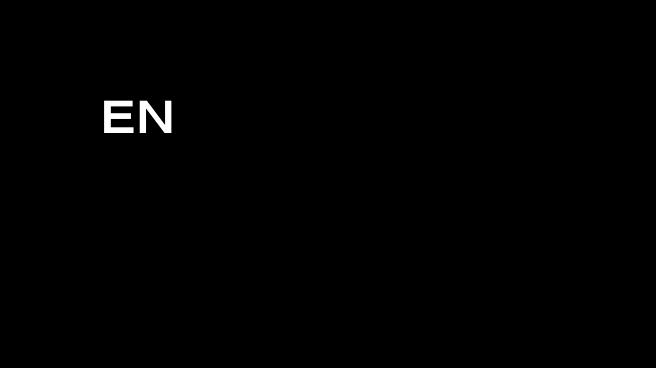

Texto a traducir:$C


In [50]:
#Modulo de pruebas con entrada por teclado
categories = txt_to_dict('categories.txt') ; expresions = txt_to_dict('expresions.txt') ; expresions_final = txt_to_dict('expresions_final.txt')
texto = ''; prev_expre = ''; order = ['tag','lemma','word','expresion','gender','number','time']
while texto != '$C':
    texto = input("Texto a traducir:")
    if texto == '$C': continue
    lw = tk.tokenize(texto.replace('\n',''))
    # split list of words in sentences, return list of sentences
    ls = sp.split(lw)
    # perform morphosyntactic analysis and disambiguation
    ls = morfo.analyze(ls)
    ls = tagger.analyze(ls)
    ls = sen.analyze(ls);
    ls = wsd.analyze(ls);
    #ls = parser.analyze(ls);  
    # do whatever is needed with processed sentences 
    print ('Input:'+texto+'\n')
    print ('Output:'+'\n')
    #out = ProcessSentences(ls,sdb, exceptions, categories, expresions, expresions_final)
    out = ProcessSentences(ls,sdb, categories, expresions, expresions_final)
    print ('\n')    
    input_path =  os.getcwd()
    clip = []
    filenames = listdir(input_path+'/Images/')
    for lemmas in out.split():
        spell_flag = False
        if lemmas.find('-') != -1:
            letters = lemmas.replace('-','')
            letters = (letters)+'.gif'
            spell_flag = True
        lemmas_ = (lemmas)
        lemmas = (lemmas)+'.gif'
        if lemmas in filenames:
            if spell_flag == True:
                for l in letters:
                    clip.append((VideoFileClip(input_path+'/Images/'+l)))
            else:
                clip.append((VideoFileClip(input_path+'/Images/'+lemmas)).set_duration(2))
        else:

            if spell_flag == True:
                letters = letters.replace('.gif','')
                for l in letters:
                    img = Image.open(input_path+'/Images/default.jpg')
                    draw = ImageDraw.Draw(img)
                    font = ImageFont.truetype("SSF.ttf", 45)
                    draw.text((260,170),l,(255,255,255),font=font)
                    img.save('sample_out.jpg')
                    clip.append((VideoFileClip(input_path+'/sample_out.jpg')).set_duration(0.5))
            else: 
                img = Image.open(input_path+'/Images/default.jpg')
                draw = ImageDraw.Draw(img)
                font = ImageFont.truetype("SSF.ttf", 45)
                draw.text((100,100),lemmas_,(255,255,255),font=font)
                img.save('sample_out.jpg')
                clip.append((VideoFileClip(input_path+'/sample_out.jpg')).set_duration(1))            
    if len(clip)>0:
        composition = concatenate_videoclips(clip)
        composition.write_gif('out.gif', fps=10)
        x = Imagepy(filename="out.gif", width=700) 
        display(x)
    else:
        print ('No disponible')


Di algo:
Dijiste: quiero tomarme una cerveza
Input:quiero tomarme una cerveza

Output:

QUERER TOMAR ME CERVEZA 
[MoviePy] Building file out.gif with imageio



 98%|█████████▊| 40/41 [00:02<00:00, 14.38it/s]


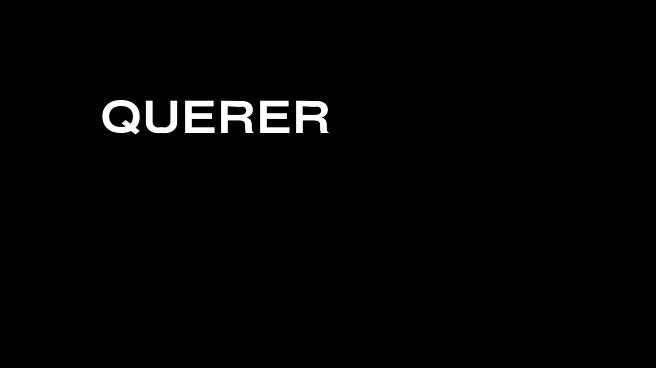

In [49]:
##Modulo de pruebas con reconocimiento de audio.
r = sr.Recognizer()
with sr.Microphone() as source:
    print("Di algo:")
    audio = r.listen(source)
#Speech recognition using Google Speech Recognition
try:
    text = r.recognize_google(audio,language = "es-ES")
    print("Dijiste: " + text)
except sr.UnknownValueError:
    print("Google Speech Recognition could not understand audio")
    text = ''
except sr.RequestError as e:
    print("Could not request results from Google Speech Recognition service; {0}".format(e))
    text = ''

categories = txt_to_dict('categories.txt') ; expresions = txt_to_dict('expresions.txt') ; expresions_final = txt_to_dict('expresions_final.txt')
prev_expre = ''

lw = tk.tokenize(text.replace('\n',''))
# split list of words in sentences, return list of sentences
ls = sp.split(lw)
# perform morphosyntactic analysis and disambiguation
ls = morfo.analyze(ls)
ls = tagger.analyze(ls)
ls = sen.analyze(ls);
ls = wsd.analyze(ls);
#ls = parser.analyze(ls);  
# do whatever is needed with processed sentences 
print ('Input:'+text+'\n')
print ('Output:'+'\n')
#out = ProcessSentences(ls,sdb, exceptions, categories, expresions, expresions_final)
out = ProcessSentences(ls,sdb, categories, expresions, expresions_final)
input_path =  os.getcwd()
clip = []
filenames = listdir(input_path+'/Images/')
for lemmas in out.split():
    spell_flag = False
    if lemmas.find('-') != -1:
        letters = lemmas.replace('-','')
        letters = (letters)+'.gif'
        spell_flag = True
    lemmas_ = (lemmas)
    lemmas = (lemmas)+'.gif'
    if lemmas in filenames:
        if spell_flag == True:
            for l in letters:
                clip.append((VideoFileClip(input_path+'/Images/'+l)))
        else:
            clip.append((VideoFileClip(input_path+'/Images/'+lemmas)).set_duration(2))
    else:

        if spell_flag == True:
            letters = letters.replace('.gif','')
            for l in letters:
                img = Image.open(input_path+'/Images/default.jpg')
                draw = ImageDraw.Draw(img)
                font = ImageFont.truetype("SSF.ttf", 45)
                draw.text((260,170),l,(255,255,255),font=font)
                img.save('sample_out.jpg')
                clip.append((VideoFileClip(input_path+'/sample_out.jpg')).set_duration(0.5))
        else: 
            img = Image.open(input_path+'/Images/default.jpg')
            draw = ImageDraw.Draw(img)
            font = ImageFont.truetype("SSF.ttf", 45)
            draw.text((100,100),lemmas_,(255,255,255),font=font)
            img.save('sample_out.jpg')
            clip.append((VideoFileClip(input_path+'/sample_out.jpg')).set_duration(1))            
if len(clip)>0:
    composition = concatenate_videoclips(clip)
    composition.write_gif('out.gif', fps=10)
    x = Imagepy(filename="out.gif", width=700) 
    display(x)
else:
    print ('No disponible')
